<a href="https://colab.research.google.com/github/sultankeles/Breast_Cancer_Diagnosis/blob/main/Breast_Cancer_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YAPILACAKLAR:

* Train-valudation-test verilrini düzenle/değiştir.

* Epoch ları arttır.

* Kalan modelleri oluştur.

* Karşılaştırma yap.

* Time kayıt kısımlarını kontrol et, compare kısmı için.

* Kodları ve açıklamaların kontrolünü yap ve düzenle.

# **1. Upload Dataset**

## 1.1. Extract .zip file retrieved from drive

In [2]:
!pip install -q gdown

In [3]:
import zipfile
import gdown
import os

# Define file ID and output paths
file_id = "1746ML0cBtTYZb-O-kQ39gd9GfhvW0kt4"
zip_output = "INbreast_Release.zip"
extract_to = "/content/INbreast_Extracted"

# Download zip from Google Drive
gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_output, quiet=False)

# Extract the zip file
with zipfile.ZipFile(zip_output, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("ZIP file downloaded and extracted successfully.")

Downloading...
From (original): https://drive.google.com/uc?id=1746ML0cBtTYZb-O-kQ39gd9GfhvW0kt4
From (redirected): https://drive.google.com/uc?id=1746ML0cBtTYZb-O-kQ39gd9GfhvW0kt4&confirm=t&uuid=7cc59f7c-f16f-45c9-9002-b89dcaea14ff
To: /content/INbreast_Release.zip
100%|██████████| 2.01G/2.01G [00:35<00:00, 56.4MB/s]


ZIP file downloaded and extracted successfully.


In [4]:
dicom_dir = "/content/INbreast_Extracted/INbreast Release 1.0/AllDICOMs"
jpg_output_dir = "/content/JPGs"

## 1.2. Convert a DICOM file to a normalized JPG image

In [5]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 84.6 MB/s eta 0:00:00


In [6]:
import pydicom
import cv2
import numpy as np
import os
from tqdm import tqdm

dicom_dir = "/content/INbreast_Extracted/INbreast Release 1.0/AllDICOMs"
jpg_output_dir = "/content/JPGs"
os.makedirs(jpg_output_dir, exist_ok=True)

def convert_dicom_to_jpg(dicom_path, jpg_path):
    dcm = pydicom.dcmread(dicom_path)
    img = dcm.pixel_array.astype(float)

    # Normalize to 0–255
    img = (np.maximum(img, 0) / img.max()) * 255.0
    img = np.uint8(img)

    # Save
    cv2.imwrite(jpg_path, img)

# Conversion process
for filename in tqdm(os.listdir(dicom_dir)):
    if filename.endswith(".dcm"):
        file_id = filename.split("_")[0]  # Leading number (matches File Name in the CSV)
        dicom_path = os.path.join(dicom_dir, filename)
        jpg_path = os.path.join(jpg_output_dir, f"{file_id}.jpg")
        convert_dicom_to_jpg(dicom_path, jpg_path)

print("All DICOM files have been converted to JPG format.")

100%|██████████| 412/412 [00:52<00:00,  7.78it/s]

All DICOM files have been converted to JPG format.


## 1.3. ROI (tumor regions) are output as XML → JSON

In [7]:
import xml.etree.ElementTree as ET
import os
import json
import re

xml_dir = "/content/INbreast_Extracted/INbreast Release 1.0/AllXML"
output_json_path = "/content/annotations.json"
annotations = {}

def parse_point(point_str):
    # Remove parentheses and split into float x, y
    x, y = re.findall(r"[\d.]+", point_str)
    return {"x": int(float(x)), "y": int(float(y))}

for file in os.listdir(xml_dir):
    if not file.endswith(".xml"):
        continue

    xml_path = os.path.join(xml_dir, file)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    image_id = file.replace(".xml", "") + ".jpg"
    rois = []

    # Navigate to ROIs
    for roi_group in root.iter("array"):
        for roi in roi_group.findall("dict"):
            name = None
            points = []
            keys = list(roi)
            for i in range(len(keys)):
                if keys[i].tag == "key" and keys[i].text == "Name":
                    name = keys[i+1].text
                if keys[i].tag == "key" and keys[i].text == "Point_px":
                    # Get all point strings inside the <array>
                    px_array = keys[i+1].findall("string")
                    for p in px_array:
                        points.append(parse_point(p.text))
            if name and points:
                rois.append({
                    "label": name,
                    "points": points
                })

    if rois:
        annotations[image_id] = rois

# Save to JSON
with open(output_json_path, "w") as f:
    json.dump(annotations, f, indent=4)

print(f"Parsed {len(annotations)} images with ROI annotations.")

Parsed 343 images with ROI annotations.


# **3. Preprocessing & Augmentation**

In [8]:
import os

base_path = "/content/INbreast_Extracted/INbreast Release 1.0"

for root, dirs, files in os.walk(base_path):
    print(f"\n {root}")

    # Print subdirectories
    if dirs:
        print(f"   >Subdirectories: {dirs}")

    # Print the first 5 files
    if files:
        for f in files[:5]:
            print(f"    - {f}")


 /content/INbreast_Extracted/INbreast Release 1.0
   >Subdirectories: ['PectoralMuscle', 'AllROI', 'AllDICOMs', 'MedicalReports', 'AllXML']
    - README.txt
    - INbreast.xls
    - inbreast.pdf
    - INbreast.csv

 /content/INbreast_Extracted/INbreast Release 1.0/PectoralMuscle
   >Subdirectories: ['Pectoral Muscle ROI', 'Pectoral Muscle XML']

 /content/INbreast_Extracted/INbreast Release 1.0/PectoralMuscle/Pectoral Muscle ROI
    - 50996083_muscle.roi
    - 22678833_muscle.roi
    - 53582764_muscle.roi
    - 24055149_muscle.roi
    - 24065380_muscle.roi

 /content/INbreast_Extracted/INbreast Release 1.0/PectoralMuscle/Pectoral Muscle XML
    - 50998177_muscle.xml
    - 53581124_muscle.xml
    - 53587104_muscle.xml
    - 53580831_muscle.xml
    - 22613822_muscle.xml

 /content/INbreast_Extracted/INbreast Release 1.0/AllROI
    - 24065860.roi
    - 22614568.roi
    - 20587226.roi
    - 50993976.roi
    - 22670301.roi

 /content/INbreast_Extracted/INbreast Release 1.0/AllDICOMs
    - 

## 3.1. Data Reading and Review

The INbreast dataset is provided in .csv format and is separated by a semicolon (;).

Therefore, when reading the dataset with pandas, the sep=";" parameter is given.

Otherwise, the columns are separated incorrectly and the data is loaded incorrectly.

In [9]:
import pandas as pd

csv_path = "/content/INbreast_Extracted/INbreast Release 1.0/INbreast.csv"

# Use sep=";" because the file is separated with semicolons
df = pd.read_csv(csv_path, sep=";")

# Create the file name with a .jpg extension
df["filename"] = df["File Name"].astype(str) + ".jpg"

# Drop unnecessary columns and create our label set
df_clean = df[["filename", "Laterality", "View", "ACR", "Bi-Rads"]].copy()
df_clean.columns = ["filename", "laterality", "view", "acr_density", "birads_label"]

# Take a look at the first few rows
df_clean.head()

,filename,laterality,view,acr_density,birads_label
0,22678622.jpg,R,CC,4,1
1,22678646.jpg,L,CC,4,3
2,22678670.jpg,R,MLO,4,1
3,22678694.jpg,L,MLO,4,3
4,22614074.jpg,R,CC,2,5


## 3.2. BI-RADS Class Distribution

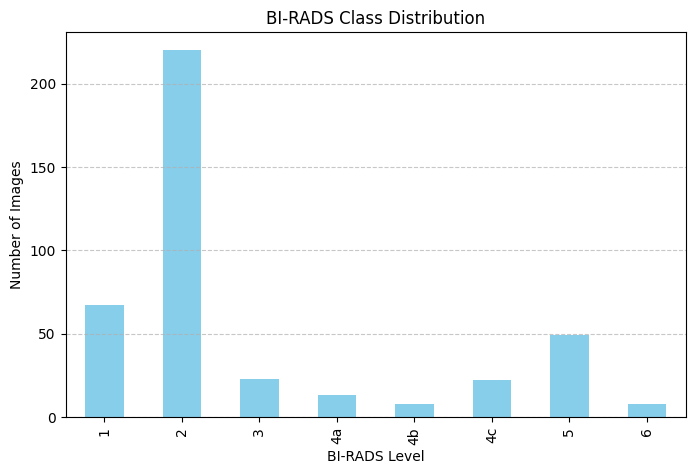

In [10]:
import matplotlib.pyplot as plt

# Count class distribution
birads_counts = df_clean["birads_label"].value_counts().sort_index()

# Visualize
plt.figure(figsize=(8, 5))
birads_counts.plot(kind="bar", color="skyblue")
plt.title("BI-RADS Class Distribution")
plt.xlabel("BI-RADS Level")
plt.ylabel("Number of Images")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### 3.2.1. Sorting Images into Folders Based on BI-RADS Levels

* The .jpg files were copied into folders based on their classes using the df_clean DataFrame.

* Folder names were given as: "BI-RADS-1", "BI-RADS-2", "BI-RADS-3", "BI-RADS-4a", "BI-RADS-4b", "BI-RADS-4ac", "BI-RADS-5", "BI-RADS-6".

In [11]:
import os
import shutil
from tqdm import tqdm

# Main directories
img_source_dir = "/content/JPGs"
output_dir = "/content/BI-RADS_split"
os.makedirs(output_dir, exist_ok=True)

# Copy images into folders by BI-RADS label
for _, row in tqdm(df_clean.iterrows(), total=len(df_clean), desc="Copying images"):
    label = str(row["birads_label"]).strip()
    src_path = os.path.join(img_source_dir, row["filename"])
    class_dir = os.path.join(output_dir, f"BIRADS_{label}")
    os.makedirs(class_dir, exist_ok=True)

    dst_path = os.path.join(class_dir, row["filename"])

    try:
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)
        else:
            print(f"Warning: {src_path} not found.")
    except Exception as e:
        print(f"Error copying {src_path} -> {dst_path}: {e}")

Copying images: 100%|██████████| 410/410 [00:00<00:00, 1009.77it/s]


In [12]:
# Count number of images per class
class_counts = {}

for class_name in sorted(os.listdir(output_dir)):
    class_path = os.path.join(output_dir, class_name)
    if os.path.isdir(class_path):
        num_files = len(os.listdir(class_path))
        class_counts[class_name] = num_files

# Show
for label, count in class_counts.items():
    print(f"{label}: {count} images")

BIRADS_1: 67 images
BIRADS_2: 220 images
BIRADS_3: 23 images
BIRADS_4a: 13 images
BIRADS_4b: 8 images
BIRADS_4c: 22 images
BIRADS_5: 49 images
BIRADS_6: 8 images


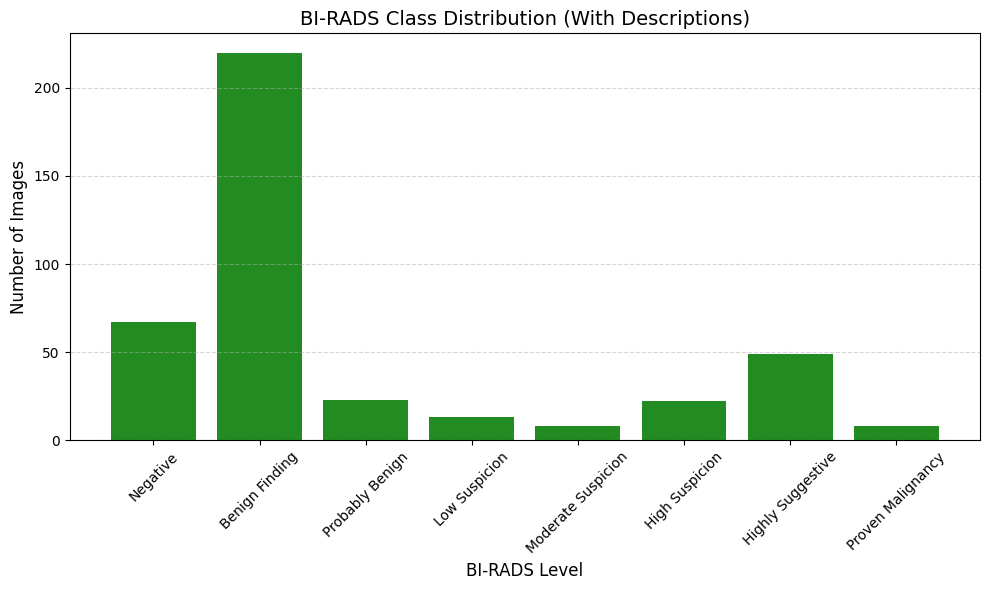

In [13]:
import matplotlib.pyplot as plt

# Label descriptions
label_map = {
    "1": "Negative",
    "2": "Benign Finding",
    "3": "Probably Benign",
    "4a": "Low Suspicion",
    "4b": "Moderate Suspicion",
    "4c": "High Suspicion",
    "5": "Highly Suggestive",
    "6": "Proven Malignancy"
}

# Helper function: BIRADS_4a → "4a"
def extract_label(folder_name):
    return folder_name.split("_")[-1].lower()

# Filter and sort folders for plotting
filtered = {k: v for k, v in class_counts.items() if k.startswith("BIRADS_")}
sorted_labels = sorted(filtered.keys(), key=lambda x: extract_label(x))

# Plot the chart
plt.figure(figsize=(10, 6))
plt.bar(
    [label_map.get(extract_label(l), extract_label(l)) for l in sorted_labels],
    [filtered[l] for l in sorted_labels],
    color="forestgreen"
)
plt.title("BI-RADS Class Distribution (With Descriptions)", fontsize=14)
plt.xlabel("BI-RADS Level", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 3.3. Augmentation

Nested break statements were handled correctly.

The production count was controlled directly using a while loop.

Simplified using print instead of tqdm (can be added again if needed).

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import os

# Original folder
base_dir = "/content/BI-RADS_split"

# Augmentation settings
datagen = ImageDataGenerator(
    rotation_range=2,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Target: 150 samples per class (except BIRADS_2)
target_count = 150

for class_name in sorted(os.listdir(base_dir)):
    if class_name == "BIRADS_2":
        continue  # no augmentation for this class

    class_path = os.path.join(base_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.endswith(".jpg")]
    current_count = len(images)
    to_generate = target_count - current_count

    print(f" {class_name}: {current_count} → {target_count} (augment: {to_generate})")

    if to_generate <= 0:
        continue

    generated = 0
    while generated < to_generate:
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size=(224, 224))
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            for batch in datagen.flow(x, batch_size=1,
                                       save_to_dir=class_path,
                                       save_prefix="aug",
                                       save_format="jpg"):
                generated += 1
                if generated >= to_generate:
                    break
            if generated >= to_generate:
                break

 BIRADS_1: 67 → 150 (augment: 83)
 BIRADS_3: 23 → 150 (augment: 127)
 BIRADS_4a: 13 → 150 (augment: 137)
 BIRADS_4b: 8 → 150 (augment: 142)
 BIRADS_4c: 22 → 150 (augment: 128)
 BIRADS_5: 49 → 150 (augment: 101)
 BIRADS_6: 8 → 150 (augment: 142)


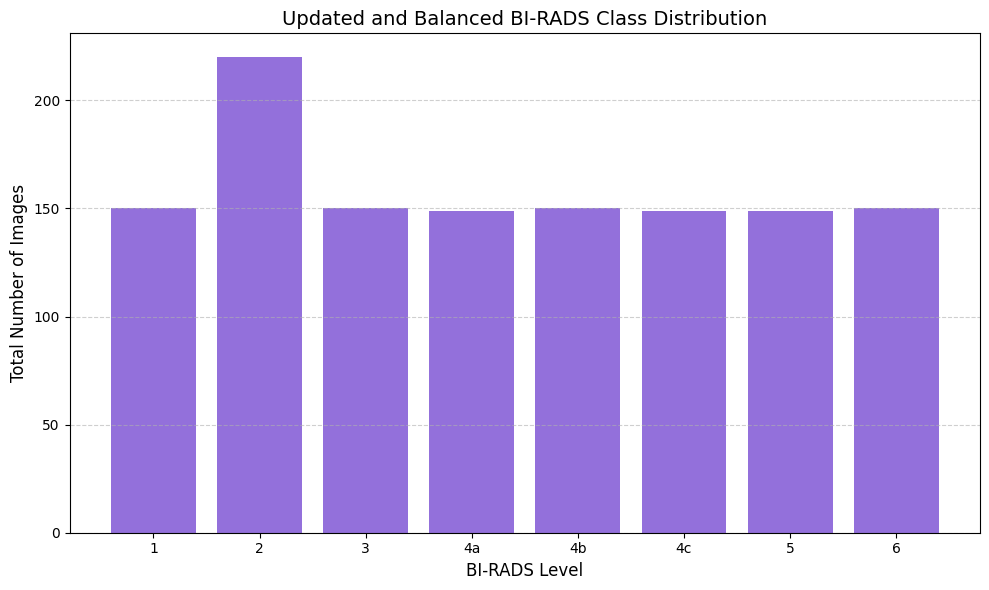

In [15]:
import matplotlib.pyplot as plt
import os

# Path to the updated (augmented) folder
augmented_base_dir = "/content/BI-RADS_split"

# Get updated image counts per class
birads_counts_clean = {}
for class_name in sorted(os.listdir(augmented_base_dir)):
    class_dir = os.path.join(augmented_base_dir, class_name)
    if os.path.isdir(class_dir):
        count = len([f for f in os.listdir(class_dir) if f.endswith(".jpg")])
        birads_counts_clean[class_name] = count

# X-axis labels
x_labels = [label.split("_")[-1] for label in birads_counts_clean.keys()]
y_counts = list(birads_counts_clean.values())

# Plot the chart
plt.figure(figsize=(10, 6))
plt.bar(x_labels, y_counts, color="mediumpurple")
plt.title("Updated and Balanced BI-RADS Class Distribution", fontsize=14)
plt.xlabel("BI-RADS Level", fontsize=12)
plt.ylabel("Total Number of Images", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# **4. Train-Test-Split**

Scan the BI-RADS_split directory.

Retrieve the full path and label of each image.

Store them in a DataFrame.

Then split using train_test_split.

In [16]:
import numpy as np
import cv2
from glob import glob
import os

# Root directory where your image folders (e.g., BIRADS_1, BIRADS_2, ...) are located
base_path = "/content/BI-RADS_split"

# Desired image size for the model (e.g., 224x224)
img_size = (224, 224)

X = []
y = []

# Loop through each class folder
for class_folder in sorted(os.listdir(base_path)):
    folder_path = os.path.join(base_path, class_folder)
    if not os.path.isdir(folder_path):
        continue

    # Extract the label from the folder name (e.g., "BIRADS_3" → "3")
    label = class_folder.split("_")[-1]

    # Find all JPG images in this class folder
    image_paths = glob(os.path.join(folder_path, "*.jpg"))

    for img_path in image_paths:
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize to [0,1]
            X.append(img)
            y.append(label)

# Convert lists to numpy arrays
X = np.array(X, dtype=np.float32)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1267, 224, 224, 3)
y shape: (1267,)


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Convert string labels to numeric
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size = 0.2, stratify = y_encoded, random_state = 42)

num_classes = len(np.unique(y_train))

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)
print("Number of classes: ", num_classes)

Train shape: (1013, 224, 224, 3) (1013,)
Test shape: (254, 224, 224, 3) (254,)
Number of classes:  8


# **5. Custom CNN Model**

## 5.1. Custom CNN Architecture

      Layer                     Description
    3 x Conv2D         Deep feature extraction with increasing number of filters  
    MaxPooling2D       Reduces dimensions, concentrates information  
    Flatten            Converts the image into a vector  
    Dense (128)        Fully connected layer responsible for learning  
    Dropout (0.5)      Protection against overfitting  
    Dense (8)          Softmax output for 8 classes  


In [57]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

input_shape = (224, 224, 3)

model_cnn = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(num_classes, activation='softmax')
])

model_cnn.compile(
    optimizer = Adam(learning_rate = 1e-4),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)
model_cnn.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,464 (49.36 MB)

 Trainable params: 12,939,464 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

      Callback                   What It Does
    EarlyStopping              Stops training early if validation performance doesn't improve
    ModelCheckpoint            Saves the model with the best validation performance as a .h5 file

> restore_best_weights=True → Restores the best epoch’s weights at the end of training

> save_best_only=True → Saves only the best model to the .h5 file

> patience=5 → Stops if there is no improvement for 5 consecutive epochs

In [58]:
# EarlyStopping
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

In [59]:
# ModelCheckpoint
checkpoint = ModelCheckpoint(
    "best_model_cnn.keras",        # Filename to save the best model
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [60]:
import time
start_time = time.time()

history_cnn = model_cnn.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

end_time = time.time()
minutes, seconds = divmod(end_time - start_time, 60)
print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.1633 - loss: 2.0562
Epoch 1: val_accuracy improved from -inf to 0.31496, saving model to best_model_cnn.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.1644 - loss: 2.0549 - val_accuracy: 0.3150 - val_loss: 1.8504
Epoch 2/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3323 - loss: 1.7814
Epoch 2: val_accuracy improved from 0.31496 to 0.43701, saving model to best_model_cnn.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.3340 - loss: 1.7775 - val_accuracy: 0.4370 - val_loss: 1.5595
Epoch 3/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4288 - loss: 1.5967
Epoch 3: val_accuracy improved from 0.43701 to 0.47638, saving model to best_model_cnn.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.4281 - loss: 1.5961 - val_accuracy: 0.4764 - val_loss: 1.4514
Epoch 4/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4556 - loss: 1.5020
Epoch 4: val_accuracy improved from

In [62]:
# Load the best model
model_cnn.load_weights("best_model_cnn.keras")

# Evaluate on test set
loss, acc = model_cnn.evaluate(X_test, y_test, verbose=1)
print(f"\n Test Accuracy: {acc:.4f} — Test Loss: {loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7479 - loss: 0.8411

 Test Accuracy: 0.7756 — Test Loss: 0.7967


## 5.2. Confusion Matrix & Classification Report

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


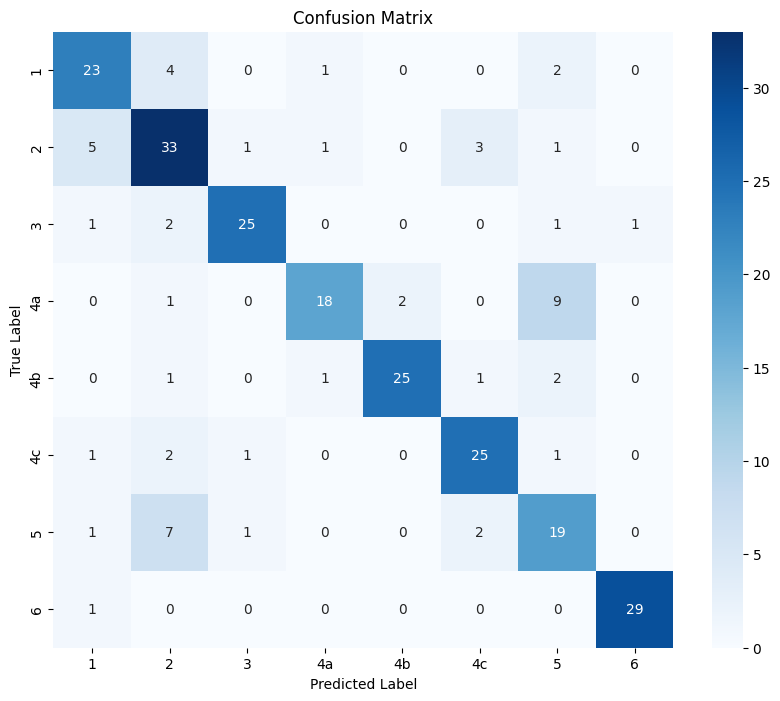

              precision    recall  f1-score   support

           1       0.72      0.77      0.74        30
           2       0.66      0.75      0.70        44
           3       0.89      0.83      0.86        30
          4a       0.86      0.60      0.71        30
          4b       0.93      0.83      0.88        30
          4c       0.81      0.83      0.82        30
           5       0.54      0.63      0.58        30
           6       0.97      0.97      0.97        30

    accuracy                           0.78       254
   macro avg       0.80      0.78      0.78       254
weighted avg       0.79      0.78      0.78       254



In [63]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# True labels
y_true = y_test  # already label-encoded integers

# Predicted labels
y_pred_probs = model_cnn.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Class names
class_names = le.classes_  # from LabelEncoder used earlier

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt='d', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names = class_names)
print(report)

## 5.3. Accuracy & Loss Graphs

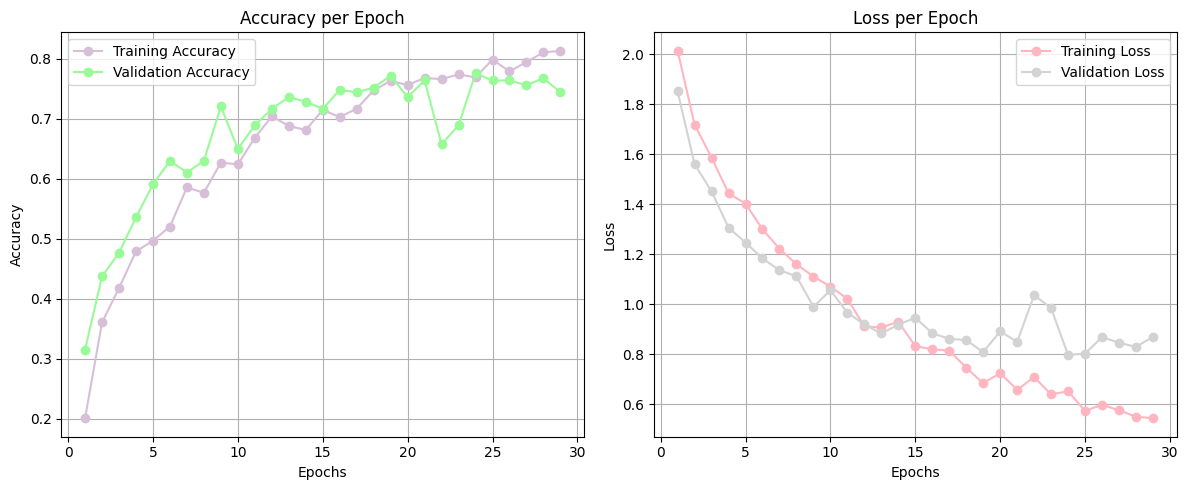

In [64]:
import matplotlib.pyplot as plt

# Extract accuracy and loss values from training history
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, color='thistle', marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, color='palegreen', marker='o', label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, color='lightpink', marker='o', label='Training Loss')
plt.plot(epochs, val_loss, color='lightgray', marker='o', label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 5.4. Prediction

Select a few random images from the test set.

Display both the model’s predicted class and the true class.

Show the images along with the predicted labels.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


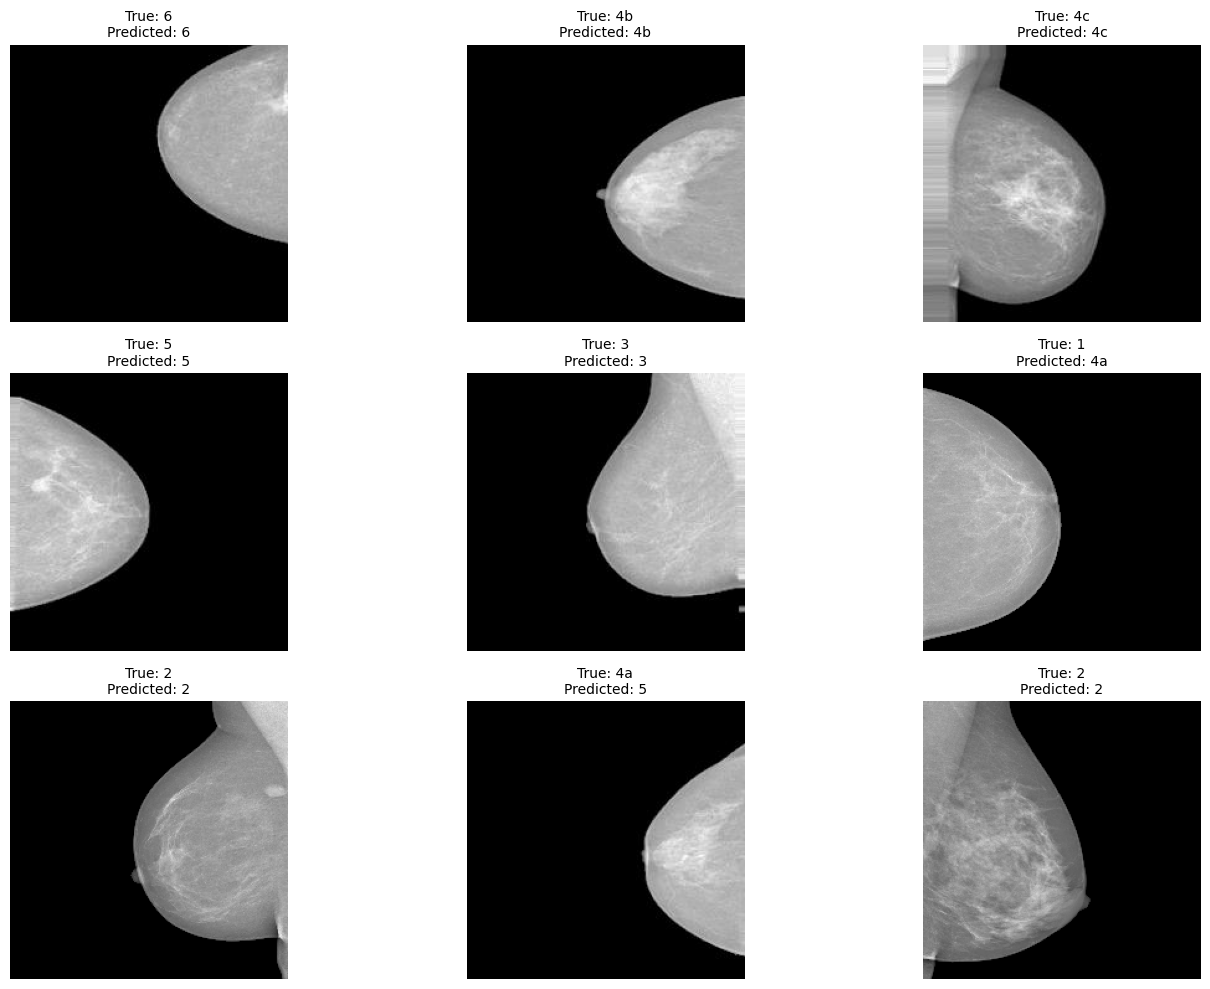

In [65]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Class labels
class_names = le.classes_

# Visualize 9 random test samples with predictions
plt.figure(figsize=(15, 10))
for i in range(9):
    index = random.randint(0, len(X_test) - 1)
    img_array = X_test[index]
    true_label = class_names[y_test[index]]

    # Prepare image for prediction
    input_img = np.expand_dims(img_array, axis=0)

    # Predict label
    pred_probs = model_cnn.predict(input_img)
    pred_label = class_names[np.argmax(pred_probs)]

    # Display image with true/predicted labels
    plt.subplot(3, 3, i + 1)
    plt.imshow(img_array)
    plt.axis("off")
    plt.title(f"True: {true_label}\nPredicted: {pred_label}", fontsize=10)

plt.tight_layout()
plt.show()

## 5.5. Draw ROI

In [66]:
pip install roifile

In [67]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Risk order of BI-RADS classes
birads_order = ['1', '2', '3', '4a', '4b', '4c', '5', '6']

# Normalization (values between 0 and 1)
birads_normalized = {label: i / (len(birads_order)-1) for i, label in enumerate(birads_order)}

# Color map: green to red (higher risk → more red)
cmap = cm.get_cmap('RdYlGn_r')  # reversed: 1 = green, 6 = red

# Get color based on class label
def get_color_from_birads(label):
    if label not in birads_normalized:
        return "gray"
    return mcolors.to_hex(cmap(birads_normalized[label]))

# Determine color based on prediction correctness
def get_roi_color_by_truth(true_label=None, pred_label=None):
    if true_label is None:
        return "mediumpurple"
    if pred_label != true_label:
        return "black"  # wrong prediction → black
    return get_color_from_birads(true_label)

# Generate color palette for each class
color_palette = {label: get_color_from_birads(label) for label in birads_order}
color_palette

<ipython-input-67-1962c5b44f26>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn_r')  # reversed: 1 = green, 6 = red


{'1': '#006837',
 '2': '#39a758',
 '3': '#9dd569',
 '4a': '#e3f399',
 '4b': '#fee999',
 '4c': '#fca55d',
 '5': '#e34933',
 '6': '#a50026'}

In [68]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import os

# Function to calculate polygon area
def calculate_polygon_area(points):
    x = [p["x"] for p in points]
    y = [p["y"] for p in points]
    area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    return area

# Draw ROI with approximate polygon area and color palette
def draw_roi_with_palette(img_path, image_id, annotations, true_label=None, pred_label=None, save_dir=None):
    from matplotlib.patches import Rectangle

    # Load image
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)

    # ROI data
    rois = annotations.get(image_id, [])
    total_area = 0

    # Create figure and axes: 1x2 grid (left: image, right: color palette)
    fig, (ax_img, ax_legend) = plt.subplots(1, 2, figsize = (12, 6), gridspec_kw = {'width_ratios': [3, 1]})
    ax_img.imshow(img_np)

    for roi in rois:
        points = roi["points"]
        if len(points) < 3:
            continue
        poly_coords = [(p["x"], p["y"]) for p in points]
        area = calculate_polygon_area(points)
        total_area += area

        color = get_roi_color_by_truth(true_label, pred_label)
        polygon = patches.Polygon(
            poly_coords,
            closed = True,
            edgecolor = color,
            facecolor = color,
            alpha = 0.3,
            linewidth = 2
        )
        ax_img.add_patch(polygon)

    # Title and display settings
    title = f"True: {true_label or 'Unknown'}  Predicted: {pred_label or 'Unknown'}\n"
    title += f"ROI Area: {int(total_area)} pixels²"
    ax_img.set_title(title, fontsize = 12)
    ax_img.axis("off")

    # Palette layout settings
    box_height = 0.6
    spacing = 0.15

    extra_items = 2  # Misestimation + Unknown
    total_items = len(birads_order) + extra_items
    full_height = total_items * (box_height + spacing)

    ax_legend.set_xlim(0, 1)
    ax_legend.set_ylim(0, full_height)
    ax_legend.axis("off")

    # Draw palette boxes
    for i, label in enumerate(birads_order):
        y = i * (box_height + spacing)
        color = get_color_from_birads(label)
        ax_legend.add_patch(Rectangle((0.1, y), 0.4, box_height, color=color))
        ax_legend.text(0.55, y + box_height / 2, f"BI-RADS {label}", va = 'center', ha = 'left', fontsize = 10)

    # Misestimation box (black)
    y = len(birads_order) * (box_height + spacing)
    ax_legend.add_patch(Rectangle((0.1, y), 0.4, box_height, color="black"))
    ax_legend.text(0.55, y + box_height / 2, "Misestimation", va = 'center', ha = 'left', fontsize = 10)

    # Unknown box (purple)
    y = (len(birads_order) + 1) * (box_height + spacing)
    ax_legend.add_patch(Rectangle((0.1, y), 0.4, box_height, color="mediumpurple"))
    ax_legend.text(0.55, y + box_height / 2, "Unknown", va = 'center', ha = 'left', fontsize = 10)

    plt.tight_layout()

    if save_dir:
        os.makedirs(save_dir, exist_ok = True)
        out_path = os.path.join(save_dir, image_id.replace(".jpg", "_with_palette.png"))
        plt.savefig(out_path)
        plt.close()
    else:
        plt.show()


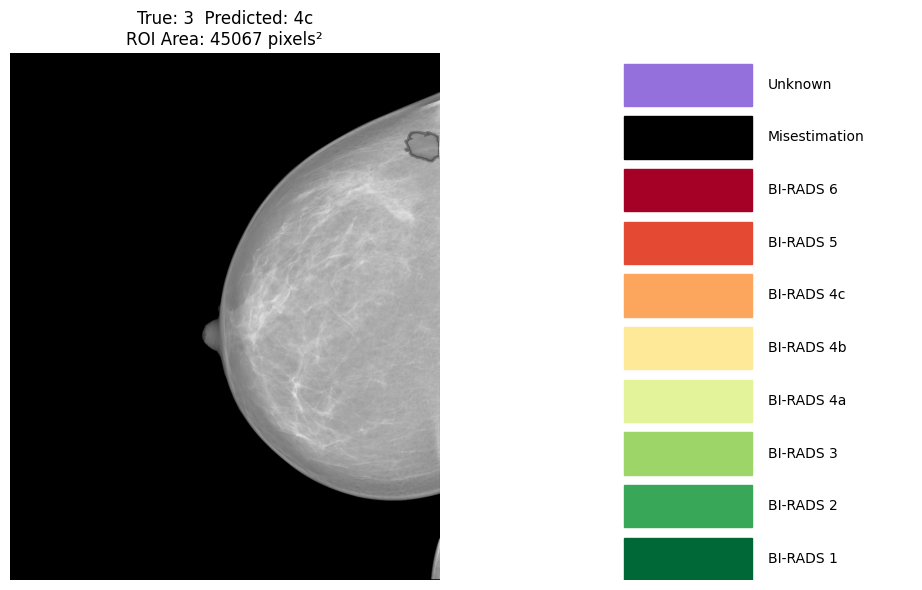

In [69]:
import random

# Filter images that contain ROIs with polygons having at least 3 points
valid_ids_with_polygon = [
    k for k, v in annotations.items()
    if any(len(roi["points"]) >= 3 for roi in v)
]

# Select a random sample
sample_id = random.choice(valid_ids_with_polygon)
img_path = f"/content/JPGs/{sample_id}"

# Randomly assign true and predicted labels (for testing purposes)
true_label = random.choice(birads_order)
pred_label = random.choice(birads_order)

# Draw the enhanced ROI visualization with color palette
draw_roi_with_palette(
    img_path=img_path,
    image_id=sample_id,
    annotations=annotations,
    true_label=true_label,
    pred_label=pred_label,
    save_dir=None
)

# **6. DenseNet121**

>DenseNet121 Training Workflow

* Model Preparation

Load DenseNet121 with ImageNet weights

Customize the top layers (classification head) according to our own classes

* Training Setup

Loss function, optimizer, metrics

EarlyStopping + ModelCheckpoint (as before)

* Training & Evaluation

Start training

Monitor validation and test accuracy

Generate Confusion Matrix and Classification Report

## 6.1. Feature Extraction

DenseNet121 was loaded with pre-trained weights from ImageNet.

The base model (feature extractor) was frozen (base_model.trainable = False).

The following layers were added on top:

GlobalAveragePooling2D

Dropout

Dense + Dropout

Softmax (for output)

Only the newly added layers were trained.

The model was compiled with the Adam optimizer, appropriate loss function, and accuracy metric.

During training:

EarlyStopping

ModelCheckpoint were used.

In [73]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Model input shape and number of classes
input_shape = (224, 224, 3)
num_classes = len(np.unique(y_train))

# Load base DenseNet121
base_model = DenseNet121(include_top = False, weights = 'imagenet', input_shape = input_shape)
base_model.trainable = False  # Freeze base initially

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation = 'softmax')(x)

# Build final model
model_densenet = Model(inputs = base_model.input, outputs = output)

# Compile
model_densenet.compile(
    optimizer=Adam(learning_rate = 1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model_densenet.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_10[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,169,736 (27.35 MB)

 Trainable params: 132,232 (516.53 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [74]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)

checkpoint = ModelCheckpoint(
    "best_model_densenet.keras",
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
)

### 6.1.1 Fitting

In [77]:
import time
start = time.time()

history_densenet = model_densenet.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 50,
    batch_size = 32,
    callbacks = [early_stop, checkpoint],
    verbose = 1
)

end = time.time()
print(f"Training time: {int((end-start)//60)} minutes {int((end-start)%60)} seconds")

Epoch 1/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7852 - loss: 0.8228
Epoch 1: val_accuracy did not improve from 0.83465
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.7847 - loss: 0.8238 - val_accuracy: 0.8150 - val_loss: 0.7392
Epoch 2/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7781 - loss: 0.8385
Epoch 2: val_accuracy did not improve from 0.83465
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.7791 - loss: 0.8355 - val_accuracy: 0.8189 - val_loss: 0.7126
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8160 - loss: 0.7550
Epoch 3: val_accuracy did not improve from 0.83465
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.8157 - loss: 0.7554 - val_accuracy: 0.8307 - val_loss: 0.6946
Epoch 4/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8096 - loss: 0.7332
Epoch 4: val_accuracy did not improve from 0.83465
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.8096 - loss: 0.7327 - val_accuracy: 0.8150 - val_loss

In [78]:
from tensorflow.keras.models import load_model

model = load_model("best_model_densenet.keras")
loss, acc = model.evaluate(X_test, y_test, verbose = 1)
print(f"\nTest Accuracy: {acc:.4f} — Test Loss: {loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 828ms/step - accuracy: 0.7998 - loss: 0.7262

Test Accuracy: 0.8425 — Test Loss: 0.6384


### 6.2.2. Confusion Matrix & Classification Report

8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step
              precision    recall  f1-score   support

           1       0.74      0.67      0.70        30
           2       0.58      0.86      0.69        44
           3       1.00      0.83      0.91        30
          4a       0.94      0.97      0.95        30
          4b       1.00      1.00      1.00        30
          4c       1.00      0.87      0.93        30
           5       0.85      0.57      0.68        30
           6       1.00      0.97      0.98        30

    accuracy                           0.84       254
   macro avg       0.89      0.84      0.86       254
weighted avg       0.87      0.84      0.85       254



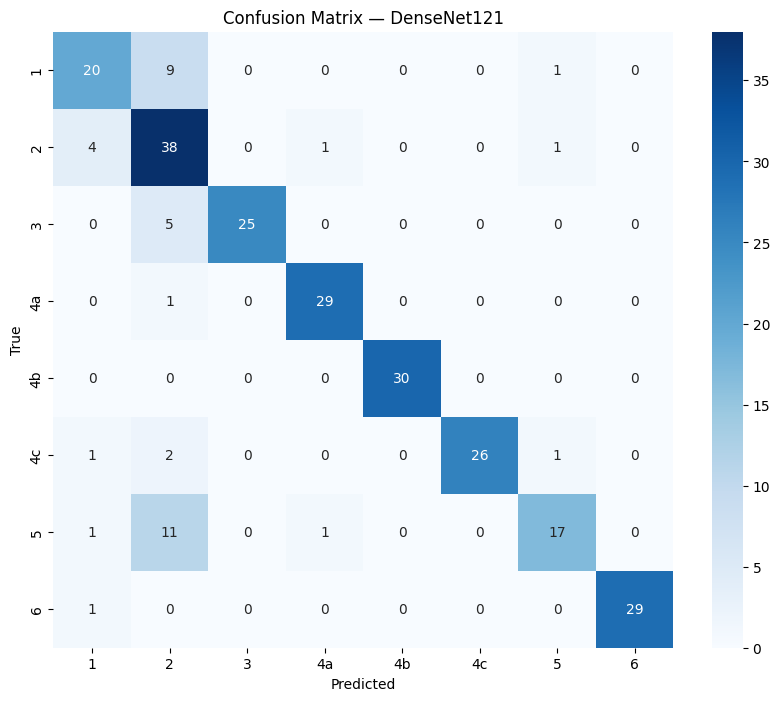

In [79]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Class labels
class_names = le.classes_

# Report
print(classification_report(y_test, y_pred, target_names = class_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.title("Confusion Matrix — DenseNet121")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 6.2. Fine-Tuning

Make the base model’s layers trainable again.

Recompile the model with a lower learning rate (lr=1e-5).

Retrain the model using early stopping and model checkpoints.

In [80]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Freeze all, then unfreeze last 30 layers
for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile with lower LR
model_densenet.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

lr_scheduler = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience = 3,
    verbose = 1,
    min_lr = 1e-6
)

# Fine-tune
fine_tune_history = model_densenet.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size = 32,
    callbacks=[early_stop, checkpoint, lr_scheduler],
    verbose = 1
)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.6886 - loss: 1.0569
Epoch 1: val_accuracy did not improve from 0.84252
32/32 ━━━━━━━━━━━━━━━━━━━━ 60s 992ms/step - accuracy: 0.6882 - loss: 1.0568 - val_accuracy: 0.8307 - val_loss: 0.6284 - learning_rate: 1.0000e-05
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7143 - loss: 0.9830
Epoch 2: val_accuracy did not improve from 0.84252
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.7149 - loss: 0.9803 - val_accuracy: 0.8268 - val_loss: 0.6206 - learning_rate: 1.0000e-05
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7613 - loss: 0.8401
Epoch 3: val_accuracy did not improve from 0.84252
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.7616 - loss: 0.8393 - val_accuracy: 0.8268 - val_loss: 0.6102 - learning_rate: 1.0000e-05
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7636 - loss: 0.7364
Epoch 4: val_accuracy did not improve from 0.84252
32/32 ━━━━━━━━━━━━━━━

In [82]:
# Overall performance on the test set
loss, acc = model_densenet.evaluate(X_test, y_test, verbose=1)
print(f"\n Test Accuracy: {acc:.4f} — Test Loss: {loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.7923 - loss: 0.7041

 Test Accuracy: 0.8307 — Test Loss: 0.6284


8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step
              precision    recall  f1-score   support

           1       0.74      0.67      0.70        30
           2       0.56      0.80      0.66        44
           3       0.93      0.83      0.88        30
          4a       0.94      0.97      0.95        30
          4b       1.00      1.00      1.00        30
          4c       0.96      0.87      0.91        30
           5       0.81      0.57      0.67        30
           6       1.00      0.97      0.98        30

    accuracy                           0.83       254
   macro avg       0.87      0.83      0.84       254
weighted avg       0.85      0.83      0.83       254



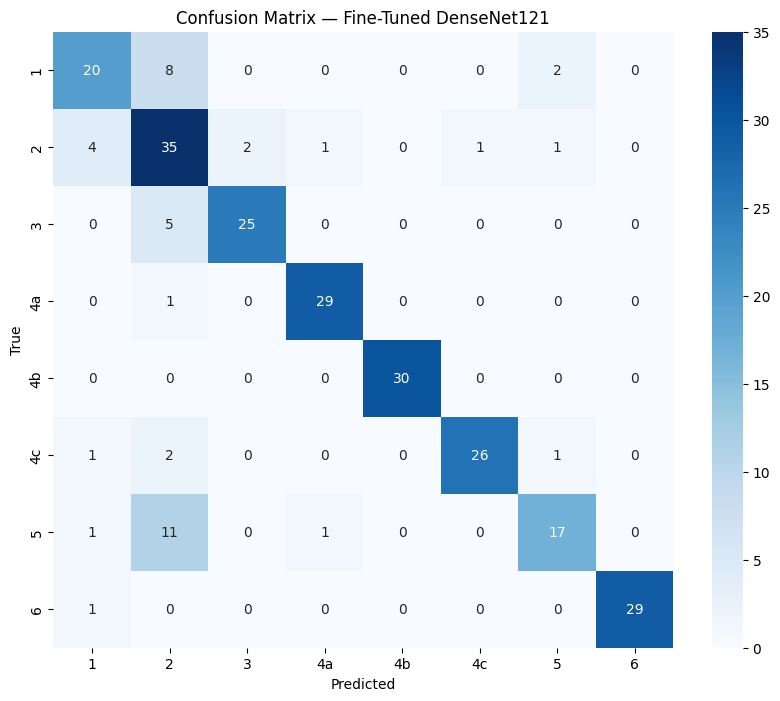

In [83]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class probabilities
y_pred_probs = model_densenet.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test
class_labels = le.classes_

# Classification report
print(classification_report(y_true, y_pred, target_names = class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_labels, yticklabels = class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — Fine-Tuned DenseNet121')
plt.show()

# **7. VGG16**

## 7.1. Feature Extraction

In [89]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = len(np.unique(y_train))

# Load base model
base_model = VGG16(include_top = False, weights = 'imagenet', input_shape = input_shape)
base_model.trainable = False

# Custom classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.6)(x)
output = Dense(num_classes, activation = 'softmax')(x)

# Build model
model_vgg = Model(inputs = base_model.input, outputs = output)

# Compile
model_vgg.compile(
    optimizer=Adam(learning_rate = 1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_vgg.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,781,384 (56.39 MB)

 Trainable params: 66,696 (260.53 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [90]:
# Class Weight Calculation
from sklearn.utils.class_weight import compute_class_weight

class_weights_raw = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train),
    y = y_train
)
class_weights = dict(enumerate(class_weights_raw))

## 7.2. Training

In [91]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)

checkpoint = ModelCheckpoint(
    "best_model_vgg16.keras",
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
)

In [92]:
import time
start = time.time()

history_vgg = model_vgg.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 50,
    batch_size = 32,
    callbacks = [early_stop, checkpoint],
    class_weight = class_weights,
    verbose = 1
)

end = time.time()
print(f"Training time: {int((end - start) // 60)} minutes {int((end - start) % 60)} seconds")

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.1284 - loss: 2.4993
Epoch 1: val_accuracy improved from -inf to 0.14173, saving model to best_model_vgg16.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 271ms/step - accuracy: 0.1283 - loss: 2.4981 - val_accuracy: 0.1417 - val_loss: 2.1681
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.1121 - loss: 2.4039
Epoch 2: val_accuracy improved from 0.14173 to 0.18110, saving model to best_model_vgg16.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.1127 - loss: 2.4026 - val_accuracy: 0.1811 - val_loss: 2.0903
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.1215 - loss: 2.2548
Epoch 3: val_accuracy improved from 0.18110 to 0.25984, saving model to best_model_vgg16.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.1219 - loss: 2.2541 - val_accuracy: 0.2598 - val_loss: 2.0499
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.1542 - loss: 2.1754
Epoch 4: val_accuracy 

## 7.3. Evaluation

In [93]:
from tensorflow.keras.models import load_model

best_model_vgg = load_model("best_model_vgg16.keras")
test_loss, test_acc = best_model_vgg.evaluate(X_test, y_test, verbose=1)

print(f"\nTest Accuracy: {test_acc:.4f} — Test Loss: {test_loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - accuracy: 0.6613 - loss: 1.8852

Test Accuracy: 0.7047 — Test Loss: 1.8690


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step
              precision    recall  f1-score   support

           1       0.57      0.70      0.63        30
           2       0.50      0.05      0.08        44
           3       0.70      0.87      0.78        30
          4a       0.97      0.97      0.97        30
          4b       0.55      1.00      0.71        30
          4c       0.74      0.83      0.78        30
           5       0.65      0.57      0.61        30
           6       0.94      0.97      0.95        30

    accuracy                           0.70       254
   macro avg       0.70      0.74      0.69       254
weighted avg       0.69      0.70      0.65       254



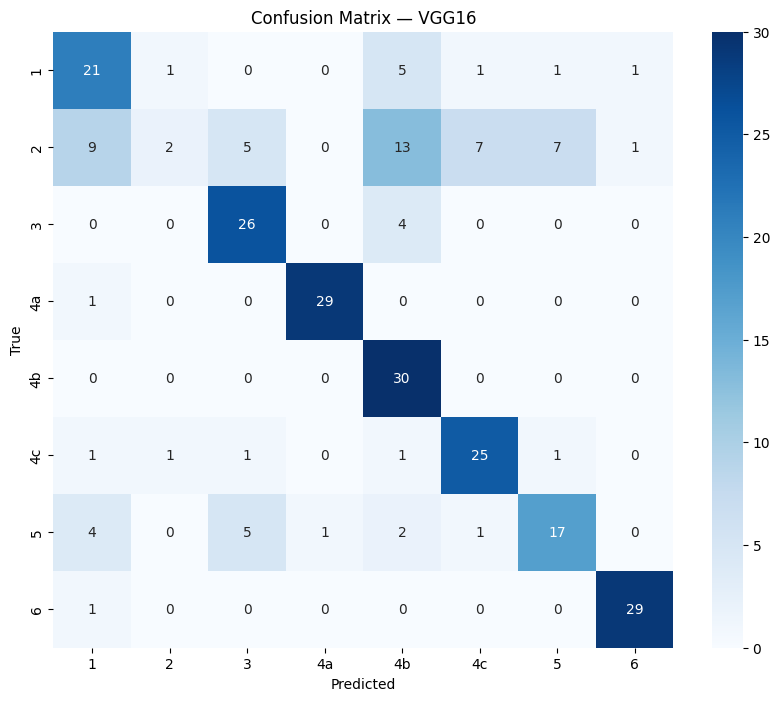

In [94]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict
y_pred_probs = best_model_vgg.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
class_names = le.classes_

# Report
print(classification_report(y_test, y_pred, target_names = class_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.title("Confusion Matrix — VGG16")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()